In [79]:
import pandas as pd
import numpy as np
import requests
import json
from config import api_key
import flr_tools
import cme_tools
import matplotlib.pyplot as plt
import scipy.stats as stats
from datetime import datetime as dt

In [3]:
start_date = "2001-01-01"
end_date = "2019-09-30"
#query_flr_url =f"https://api.nasa.gov/DONKI/FLR?startDate={start_date}&endDate={end_date}&api_key={api_key}"

In [4]:
dont_use_nasa_time_format = False
flare_alldf = flr_tools.flare_query_all(start_date, end_date, dont_use_nasa_time_format)
flare_alldf.head()

,class_type,end_time(zulu),flare_id,linked_events,peak_time(zulu),power(w/m^2),start_time(zulu)
0,B7.4,"04/03/2010, 10:58:00",2010-04-03T09:04:00-FLR-001,[{'activityID': '2010-04-03T09:54:00-CME-001'}],"04/03/2010, 09:54:00",7.400000e-07,"04/03/2010, 09:04:00"
1,M2.0,"06/12/2010, 01:02:00",2010-06-12T00:30:00-FLR-001,[None Found.],"06/12/2010, 00:57:00",2.000000e-05,"06/12/2010, 00:30:00"
2,M1.0,"08/07/2010, 18:47:00",2010-08-07T17:55:00-FLR-001,[None Found.],"08/07/2010, 18:24:00",1.000000e-05,"08/07/2010, 17:55:00"
3,C4.4,"08/14/2010, 10:31:00",2010-08-14T09:38:00-FLR-001,[{'activityID': '2010-08-14T12:30:00-SEP-001'}],"08/14/2010, 10:05:00",4.400000e-06,"08/14/2010, 09:38:00"
4,C4.5,"08/18/2010, 06:51:00",2010-08-18T04:45:00-FLR-001,[{'activityID': '2010-08-18T06:00:00-CME-001'}],"08/18/2010, 05:48:00",4.500000e-06,"08/18/2010, 04:45:00"


In [6]:
dont_use_nasa_time_format = False
cme_alldf = cme_tools.cme_query_all(start_date, end_date, dont_use_nasa_time_format)
cme_alldf.head()

,cme_id,speed,type,linked_events,start time
0,2010-04-03T09:54:00-CME-001,620,C,[{'activityID': '2010-04-03T09:04:00-FLR-001'}...,"04/03/2010, 09:54:00"
1,2010-06-13T07:32:00-CME-001,500,C,None,"06/13/2010, 07:32:00"
2,2010-06-20T03:18:00-CME-001,570,C,[{'activityID': '2010-06-23T08:00:00-IPS-001'}],"06/20/2010, 03:18:00"
3,2010-07-03T01:30:00-CME-001,625,C,None,"07/03/2010, 01:30:00"
4,2010-07-08T22:30:00-CME-001,290,S,None,"07/08/2010, 22:30:00"


In [7]:
cme_ids = cme_tools.linked_events(flare_alldf.rename(columns={'flare_id':'id'}),'CME')
flr_ids = cme_tools.linked_events(cme_alldf.rename(columns={'cme_id':'id'}),'FLR')
both = pd.DataFrame(cme_ids, columns=['flare_id','cme_id'])
new_df = both.merge(cme_alldf[["cme_id","speed","type","start time"]], on="cme_id", how='left')
new_df = new_df.rename(columns={"speed":"cme speed","type": "cme type", "start time": "cme start time"})
full_df = new_df.merge(flare_alldf[["flare_id","start_time(zulu)","peak_time(zulu)","end_time(zulu)","class_type","power(w/m^2)"]],
                      on="flare_id", how="left")
full_df = full_df.rename(columns={"start_time(zulu)":"flare start time","peak_time(zulu)": "flare peak time",
                                  "end_time(zulu)":"flare end time","class_type":"flare type","power(w/m^2)":"flare power(w/m^2)"})
full_df.head()

,flare_id,cme_id,cme speed,cme type,cme start time,flare start time,flare peak time,flare end time,flare type,flare power(w/m^2)
0,2010-04-03T09:04:00-FLR-001,2010-04-03T09:54:00-CME-001,620,C,"04/03/2010, 09:54:00","04/03/2010, 09:04:00","04/03/2010, 09:54:00","04/03/2010, 10:58:00",B7.4,7.400000e-07
1,2010-08-18T04:45:00-FLR-001,2010-08-18T06:00:00-CME-001,1091,O,"08/18/2010, 06:00:00","08/18/2010, 04:45:00","08/18/2010, 05:48:00","08/18/2010, 06:51:00",C4.5,4.500000e-06
2,2011-02-15T01:44:00-FLR-001,2011-02-15T02:25:00-CME-001,920,C,"02/15/2011, 02:25:00","02/15/2011, 01:44:00","02/15/2011, 01:56:00","02/15/2011, 02:06:00",X2.2,2.200000e-04
3,2011-02-24T07:23:00-FLR-001,2011-02-24T08:00:00-CME-001,900,C,"02/24/2011, 08:00:00","02/24/2011, 07:23:00","02/24/2011, 07:35:00","02/24/2011, 07:42:00",M3.5,3.500000e-05
4,2011-03-07T13:44:00-FLR-001,2011-03-07T14:40:00-CME-001,710,C,"03/07/2011, 14:40:00","03/07/2011, 13:44:00","03/07/2011, 14:30:00","03/07/2011, 15:08:00",M2.0,2.000000e-05


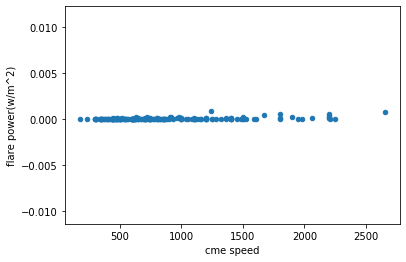

In [10]:
full_df["cme speed"] = pd.to_numeric(full_df["cme speed"], errors="coerce")
full_df["flare power(w/m^2)"] = pd.to_numeric(full_df["flare power(w/m^2)"], errors="coerce")

full_df.plot(kind="scatter", x="cme speed", y="flare power(w/m^2)")


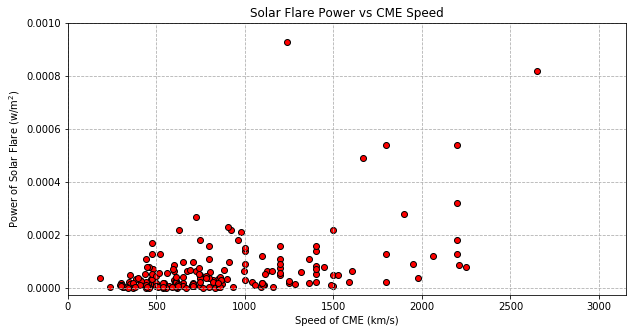

In [130]:
plt.figure(figsize=(10,5))
plt.scatter(full_df["cme speed"], full_df["flare power(w/m^2)"], facecolor='r', edgecolor='k')
plt.ylim(-0.000025, 10*10**-4)
plt.xlim(0,full_df["cme speed"].max()+500)
plt.title("Solar Flare Power vs CME Speed")
plt.xlabel("Speed of CME (km/s)")
plt.ylabel("Power of Solar Flare (w/m$^2$)")
plt.grid(linestyle='--')

In [34]:
cme_alldf["speed"] = pd.to_numeric(cme_alldf["speed"], errors="coerce")
flare_alldf["power(w/m^2)"] = pd.to_numeric(flare_alldf["power(w/m^2)"], errors="coerce")

In [10]:
new_df = full_df.dropna(how="any")

In [11]:
tstat,p = stats.ttest_ind(new_df["cme speed"], new_df["flare power(w/m^2)"], equal_var = False)

In [12]:
print(tstat,p)

21.34416423808531 1.2443141034431102e-44


Text(0.5, 0, 'Type of Event')

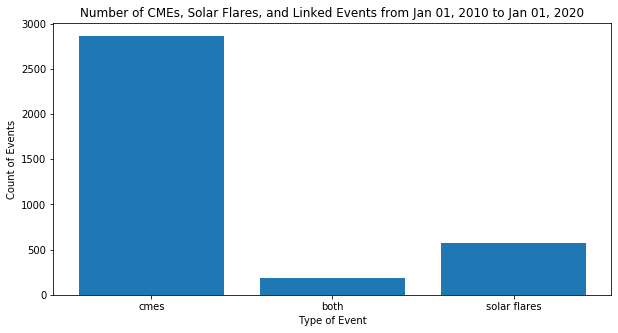

In [131]:
plt.figure(figsize=(10,5))
object_list = ["cmes", "both","solar flares"]
counts = [len(cme_alldf), len(full_df), len(flare_alldf)]
plt.bar(np.arange(len(object_list)),counts, align="center")
plt.xticks(np.arange(len(object_list)),object_list)
plt.title(f"Number of CMEs, Solar Flares, and Linked Events from {dt(2010,1,1).strftime('%b %d, %Y')} to {dt(2020,1,1).strftime('%b %d, %Y')}")
plt.ylabel("Count of Events")
plt.xlabel("Type of Event")

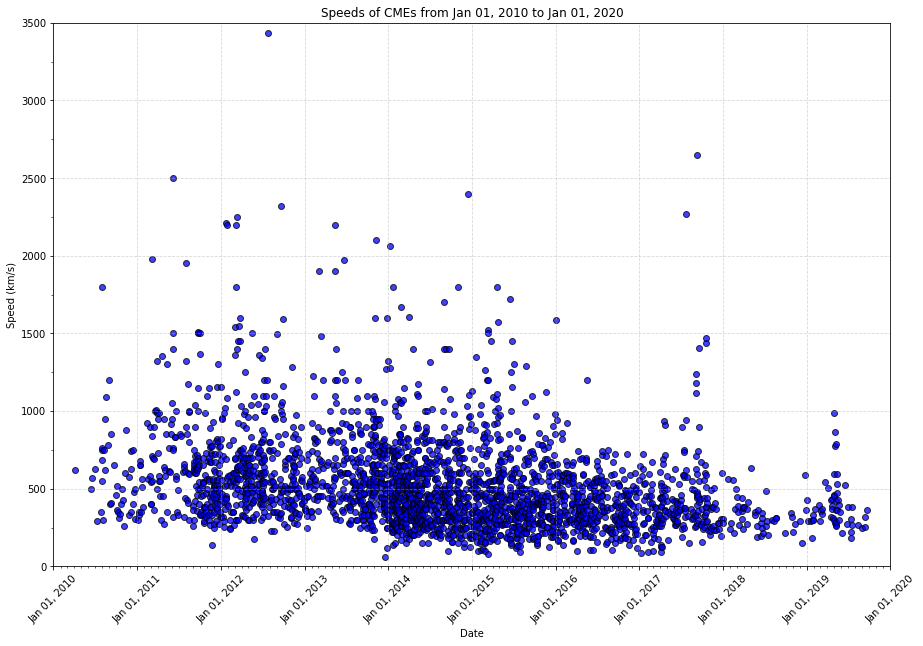

In [127]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15,10))
cme_clean_df = cme_alldf[['cme_id','speed','start time']].dropna(how="any")

dates = cme_clean_df["start time"].apply(lambda x: dt.strptime(x,'%m/%d/%Y, %H:%M:%S'))

ax.scatter(dates, cme_clean_df['speed'], facecolor = 'b', alpha = .75, edgecolor='k')

ax.set_title(f"Speeds of CMEs from {dt(2010,1,1).strftime('%b %d, %Y')} to {dt(2020,1,1).strftime('%b %d, %Y')}")
ax.set_xlabel("Date")
ax.set_xticklabels(dates,rotation=45)
ax.set_ylabel("Speed (km/s)")
ax.set_xlim(dt(2010,1,1), dt(2020,1,1))
ax.set_ylim(0,3500)


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b %d, %Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_minor_locator(months)

ax.set_yticks(np.arange(0,4000,500))
ax.set_yticks(np.arange(0,3750,250), minor=True)
ax.grid("--",which='major', alpha=0.5, linestyle='--')